This notebook displays key segmentation differences between different stains.

In [1]:
import argparse
import pathlib

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import skimage
import tifffile
from cellpose import models
from PIL import Image
from stardist.plot import render_label

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(in_notebook)

True


In [2]:
if not in_notebook:
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    parser.add_argument(
        "--clip_limit",
        type=float,
        help="Clip limit for the adaptive histogram equalization",
    )

    args = parser.parse_args()
    clip_limit = args.clip_limit
    input_dir = pathlib.Path(args.input_dir).resolve(strict=True)

else:
    input_dir = pathlib.Path(
        "../../2.illumination_correction/illum_directory/W0078_F0001"
    ).resolve(strict=True)
    clip_limit = 0.4
    optimize_segmentation = True


figures_dir = pathlib.Path("../figures").resolve()
figures_dir.mkdir(exist_ok=True, parents=True)

## Set up images, paths and functions

In [3]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]

In [4]:
image_dict = {
    "nuclei_file_paths": [],
    "nuclei": [],
    "cytoplasm1": [],
    "cytoplasm2": [],
    "cytoplasm3": [],
}

In [5]:
# split files by channel
for file in files:
    if "C4" in file.split("/")[-1]:
        image_dict["nuclei_file_paths"].append(file)
        image_dict["nuclei"].append(tifffile.imread(file).astype(np.float32))
    elif "C2" in file.split("/")[-1]:
        image_dict["cytoplasm1"].append(tifffile.imread(file).astype(np.float32))
    elif "C3" in file.split("/")[-1]:
        image_dict["cytoplasm2"].append(tifffile.imread(file).astype(np.float32))
    elif "C1" in file.split("/")[-1]:
        image_dict["cytoplasm3"].append(tifffile.imread(file).astype(np.float32))

cytoplasm1_image_list = [
    np.max(
        np.array(
            [
                cytoplasm1,
                cytoplasm2,
            ]
        ),
        axis=0,
    )
    for cytoplasm1, cytoplasm2 in zip(
        image_dict["cytoplasm1"],
        image_dict["cytoplasm2"],
    )
]
cytoplasm2_image_list = [
    np.array(cytoplasm3) for cytoplasm3 in image_dict["cytoplasm3"]
]
nuclei_image_list = [np.array(nuclei) for nuclei in image_dict["nuclei"]]

cyto1 = np.array(cytoplasm1_image_list).astype(np.int16)
cyto2 = np.array(cytoplasm2_image_list).astype(np.int16)
nuclei = np.array(nuclei_image_list).astype(np.int16)

cyto1 = skimage.exposure.equalize_adapthist(cyto1, clip_limit=clip_limit + 0.3)
cyto2 = skimage.exposure.equalize_adapthist(cyto2, clip_limit=clip_limit + 0.3)
nuclei = skimage.exposure.equalize_adapthist(nuclei, clip_limit=clip_limit)


print(cyto1.shape, cyto2.shape, nuclei.shape)

(18, 2000, 2000) (18, 2000, 2000) (18, 2000, 2000)


In [6]:
original_nuclei_image = nuclei.copy()
original_cyto1_image = cyto1.copy()
original_cyto2_image = cyto2.copy()

## Cellpose

## Cytoplasm 1

resnet_torch.py (271): You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


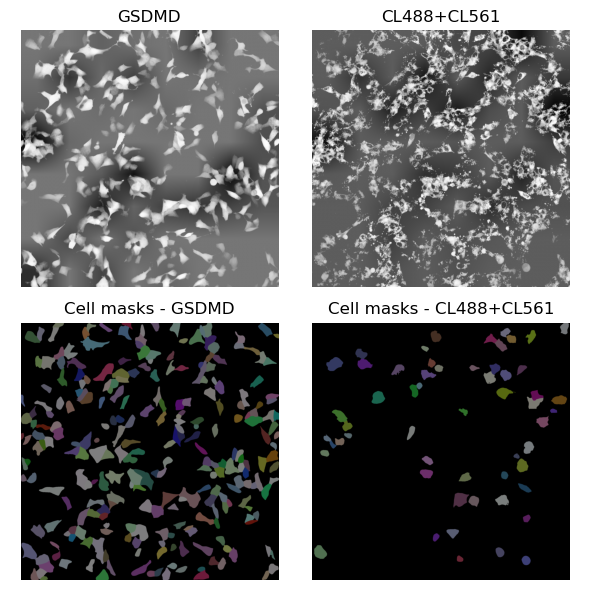

In [7]:
# model_type='cyto' or 'nuclei' or 'cyto2' or 'cyto3'
model_name = "cyto3"
model = models.Cellpose(model_type=model_name, gpu=True)

channels = [[1, 0]]  # channels=[red cells, blue nuclei]

cyto1 = np.array(cyto1)
cyto2 = np.array(cyto2)
frame_index = 5
cyto1_frame_example = cyto1[frame_index, :, :]
cyto2_frame_example = cyto2[frame_index, :, :]

# masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=channels)
masks1, flows1, styles1, diams1 = model.eval(
    cyto1_frame_example, channels=channels, diameter=100
)
masks2, flows2, styles2, diams2 = model.eval(
    cyto2_frame_example, channels=channels, diameter=100
)

if in_notebook:
    plt.figure(figsize=(6, 6))
    plt.axis("off")

    plt.subplot(2, 2, 1)
    plt.imshow(cyto2_frame_example, cmap="gray")
    plt.title("GSDMD")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(render_label(masks2))
    plt.title("Cell masks - GSDMD")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(cyto1_frame_example, cmap="gray")
    plt.title("CL488+CL561")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(render_label(masks1))
    plt.title("Cell masks - CL488+CL561")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(figures_dir / "cell_segmentation_differences.png")
    if in_notebook:
        plt.show()